In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import sys
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss, Disco
from utils import Metrics, find_threshold, DataSet, Logger
from utils import LegendreFitter, LegendreIntegral
from torch.autograd import gradcheck
torch.manual_seed(72)

In [2]:
 def plot_stuff(model,X,y,x_biased,name='Naive DNN'):
    predictions = np.array(model(torch.Tensor(X).float().to(device)).tolist()).flatten()
    metrics_test = Metrics(validation=True)
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    x_biased = (x_biased+1)*0.5 *250 
    
    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=50,alpha=0.3,color='C1',label='Background',density=True,log=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True,log=True)
    ax.set_ylabel("Normed Counts",fontsize=20)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m_t = x_biased
    sorted_m = np.argsort(m_t)
    scores = predictions[sorted_m].reshape(-1,100)
    m_t = m_t[sorted_m]
    m = m_t.reshape(-1,100).mean(axis=1)
    F_s = []
    for s in scores.reshape(50,-1):
        density = np.histogram(s,bins=20,range=(0,1))[0]
        F_s.append(np.cumsum(density)/density.sum())
    F_s = np.array(F_s).T
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=1)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    plt.show()
    return (1/JSD,R50)

In [3]:
# mbins = 10
# mcontent = 4
# li = LegendreIntegral.apply
# fitter = LegendreFitter(mbins=mbins,power=2)
# inputTensor = torch.DoubleTensor(np.random.rand(mbins,mcontent)).sort(axis=1)[0]
# inputTensor.requires_grad_(True)
# sbins = 1000
# integral = li(inputTensor,fitter,sbins
#              )
# integral
# gradcheck(li,(inputTensor,fitter,sbins
#              ),eps=0.01,atol=0.01)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#device = "cpu"

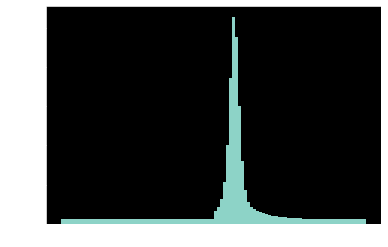

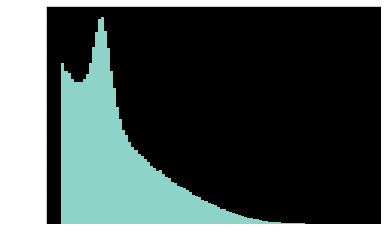

device: cuda:0


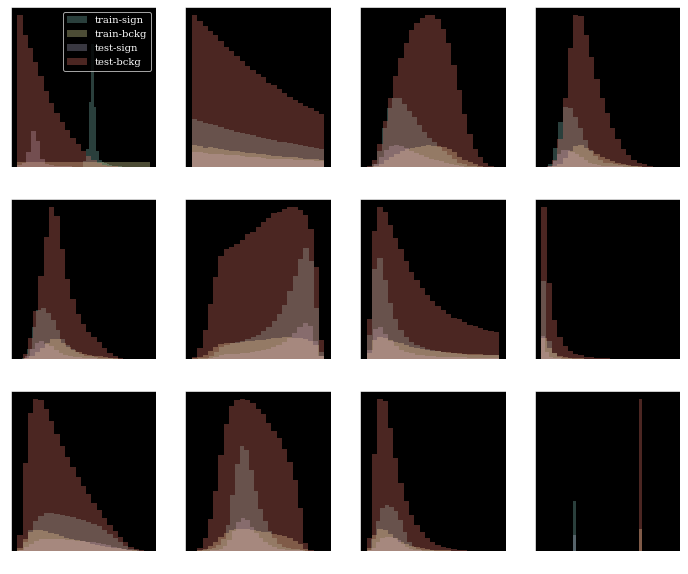

In [5]:
#dataset
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')

train_labels = train[::,-1]
val_labels   = val[::,-1]

maxdata = train.max(axis=0)
mindata = train.min(axis=0)
train = (train-mindata)/(maxdata-mindata)
#train[::,0] = 2*train[::,0]-1
train[::,0][train_labels==1] = 2*(np.argsort(train[::,0][train_labels==1]))/(train_labels==1).sum()-1

plt.hist(train[::,0],bins=100)
plt.show()

maxdata = val.max(axis=0)
mindata = val.min(axis=0)
val = (val-mindata)/(maxdata-mindata)
val[::,0] = 2*val[::,0]-1
plt.hist(val[::,0],bins=100)
plt.show()

traindataset = DataSet(samples=train[::,1:-1],
                       labels=train_labels,
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val_labels,
                    m = val[::,0])
test = files["test"]
test_labels=test[::,-1]
maxdata = test.max(axis=0)
mindata = test.min(axis=0)
test = (test-mindata)/(maxdata-mindata)
test[::,0] = 2*test[::,0]-1

print('device:', device)



# maxdata = val.max(axis=0)
# mindata = val.min(axis=0)
# val = (val-mindata)/(maxdata-mindata)

# m,dm = np.histogram(train[::,0],bins=train.shape[0],density=True)
# train[::,0] = np.cumsum(m*(dm[1]-dm[0]))
# m,dm = np.histogram(val[::,0],bins=val.shape[0],density=True)
# val[::,0] = np.cumsum(m*(dm[1]-dm[0]))
# m = train[::,0].argsort()
# m = m/m.size
#train[::,0] = 2*train[::,0]-1
# m = val[::,0].argsort()
# m = m/m.size
# val[::,0] = 2*m-1
fig, axes = plt.subplots(3,4,figsize=(12,10))
for i,ax in enumerate(axes.flatten()):
    ax.hist(train[:,i][train[:,-1]==0],bins=25,alpha=0.3,label='train-sign')
    ax.hist(train[:,i][train[:,-1]==1],bins=25,alpha=0.3,label='train-bckg')
    ax.hist(test[:,i][test[:,-1]==0],bins=25,alpha=0.3,label='test-sign')
    ax.hist(test[:,i][test[:,-1]==1],bins=25,alpha=0.3,label='test-bckg')
    ax.set_yticks([])
    if i==0: ax.legend()
    

In [6]:
params = {'epochs'     : 200,
          'interval'   : 100,
          'batch_size' : 4096,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }

# No flattening of the distribution of masses

strength 120
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (133.6s)
 Train: loss:0.3677, acc:60% || Val: loss: 0.0865, acc:85%, R50: 5.0339, 1/JSD: 1543.1715
Epoch:0200/0200  (259.8s)
 Train: loss:0.3411, acc:61% || Val: loss: 0.0898, acc:84%, R50: 17.5766, 1/JSD: 122.5793


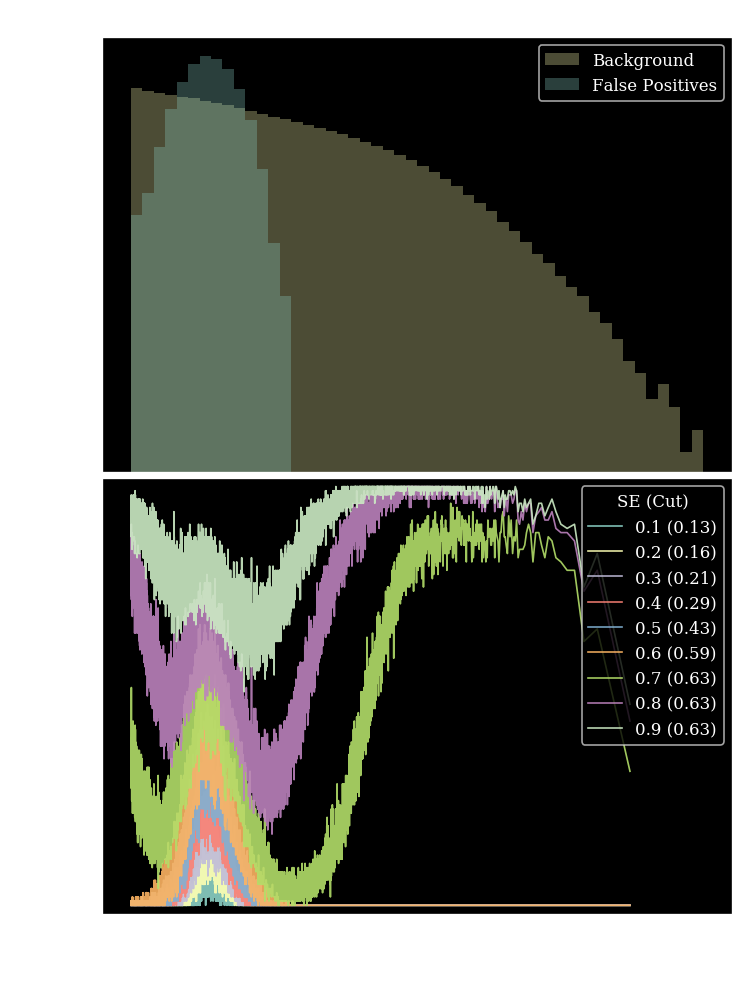

strength 100
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (133.7s)
 Train: loss:0.3492, acc:66% || Val: loss: 0.0857, acc:85%, R50: 15.0575, 1/JSD: 234.0042
Epoch:0200/0200  (261.3s)
 Train: loss:0.3348, acc:63% || Val: loss: 0.0823, acc:86%, R50: 21.1932, 1/JSD: 110.2092


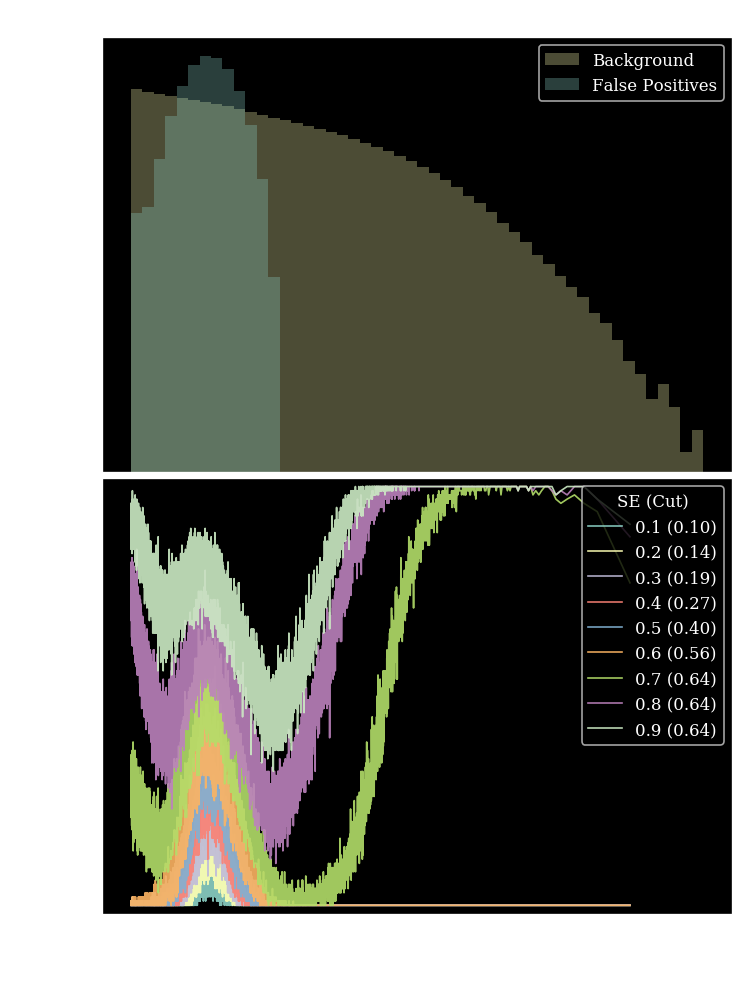

strength 75
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (136.0s)
 Train: loss:0.3239, acc:58% || Val: loss: 0.0742, acc:87%, R50: 21.9269, 1/JSD: 131.8313
Epoch:0200/0200  (263.6s)
 Train: loss:0.3111, acc:67% || Val: loss: 0.0748, acc:87%, R50: 22.7320, 1/JSD: 115.5731


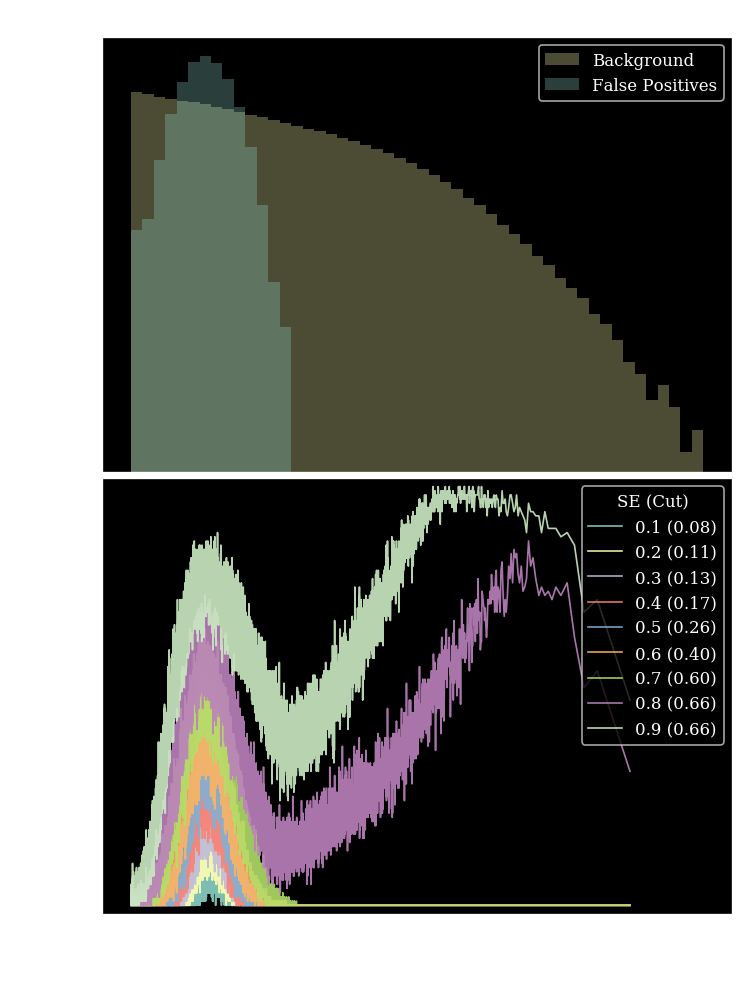

strength 50
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (136.4s)
 Train: loss:0.2983, acc:64% || Val: loss: 0.0676, acc:86%, R50: 22.6804, 1/JSD: 112.2873
Epoch:0200/0200  (266.0s)
 Train: loss:0.2856, acc:70% || Val: loss: 0.0689, acc:87%, R50: 23.4425, 1/JSD: 109.1502


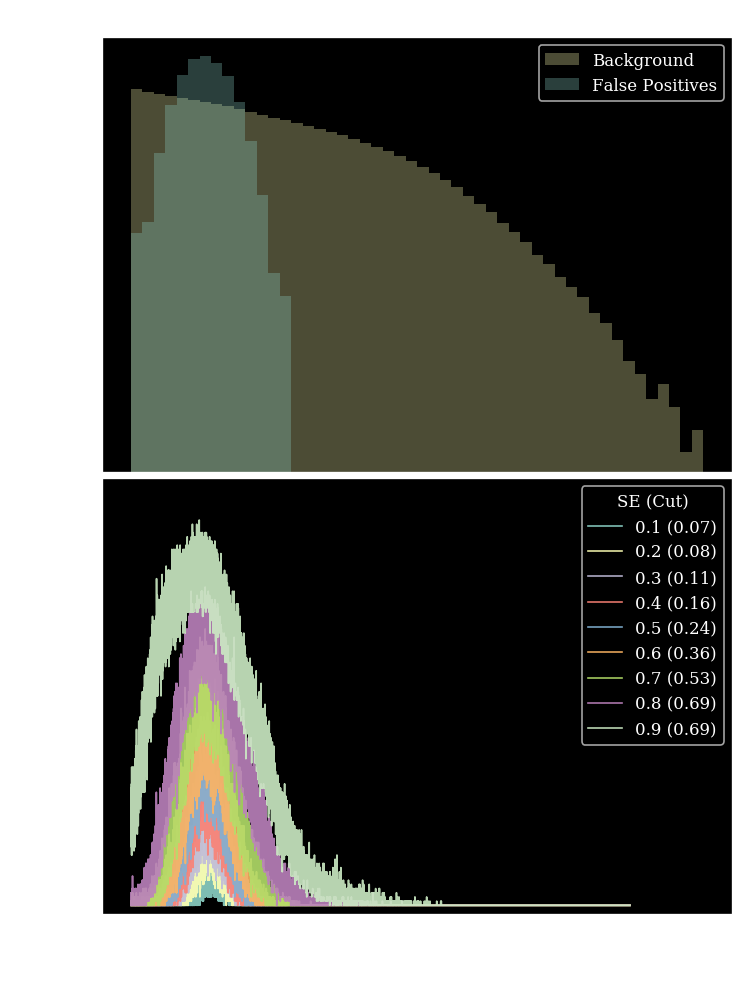

strength 10
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (154.3s)
 Train: loss:0.2240, acc:78% || Val: loss: 0.0575, acc:85%, R50: 22.7979, 1/JSD: 112.3498
Epoch:0200/0200  (282.5s)
 Train: loss:0.2145, acc:79% || Val: loss: 0.0553, acc:84%, R50: 23.8646, 1/JSD: 95.0128


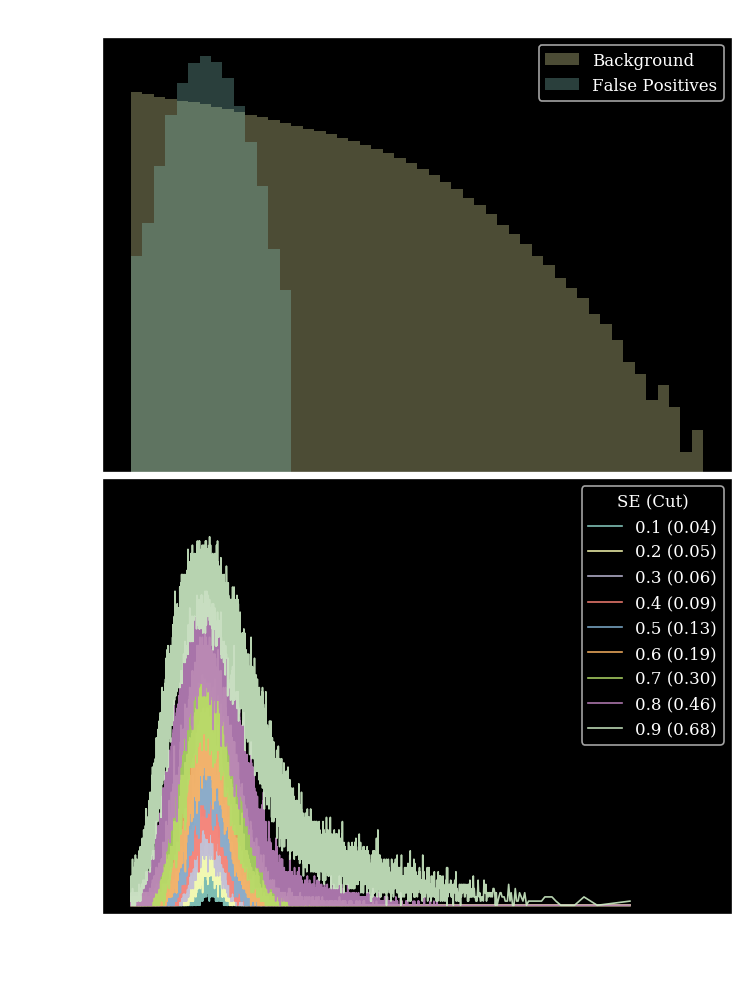

strength 5
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (135.0s)
 Train: loss:0.2132, acc:80% || Val: loss: 0.0568, acc:85%, R50: 22.8105, 1/JSD: 112.6909
Epoch:0200/0200  (277.1s)
 Train: loss:0.2011, acc:80% || Val: loss: 0.0554, acc:85%, R50: 24.0665, 1/JSD: 80.6826


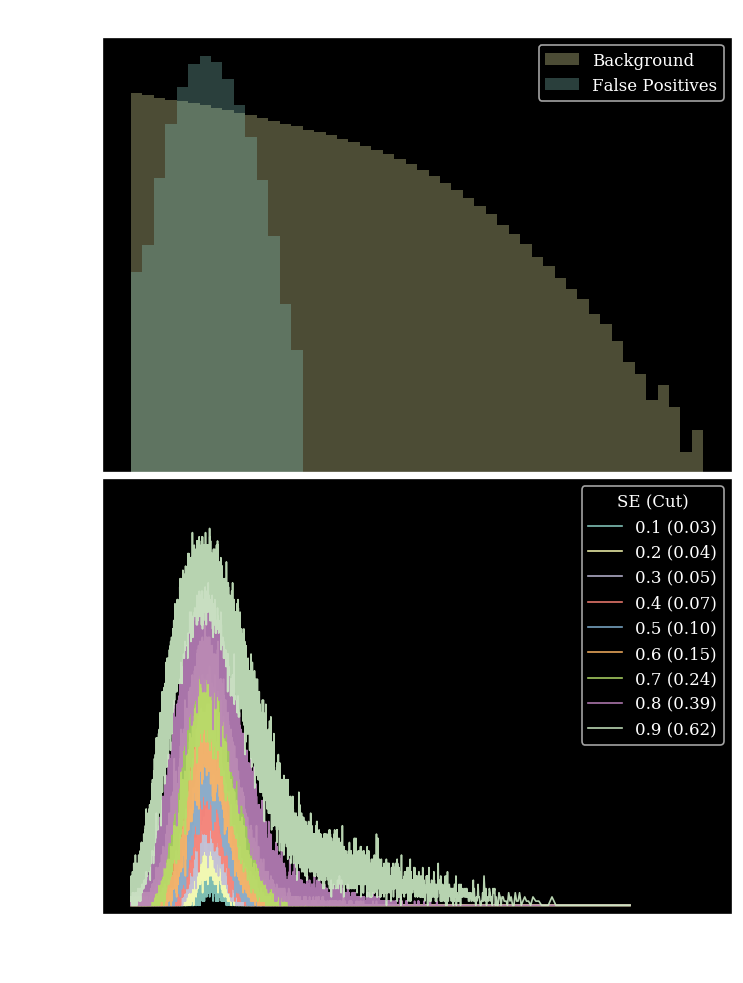

strength 1
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (135.2s)
 Train: loss:0.2028, acc:80% || Val: loss: 0.0565, acc:84%, R50: 22.7743, 1/JSD: 112.5858
Epoch:0200/0200  (263.6s)
 Train: loss:0.1903, acc:81% || Val: loss: 0.0549, acc:84%, R50: 23.8836, 1/JSD: 88.5159


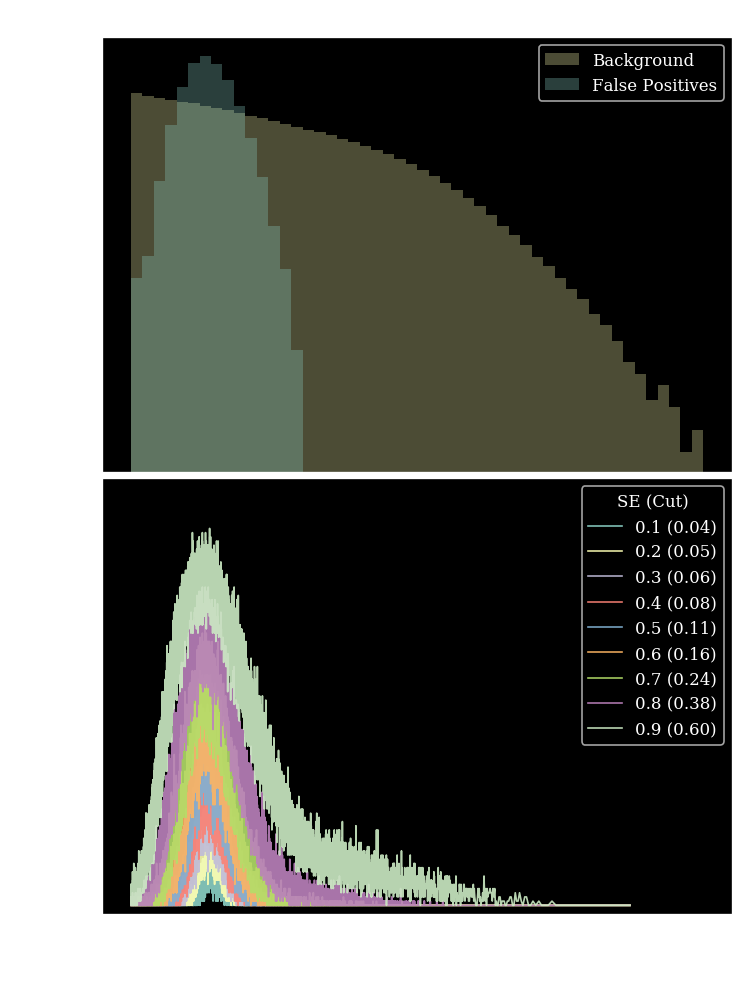

strength 0.1
Entering Training...
Epoch:0001/0200  (7.6  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (137.0s)
 Train: loss:0.2005, acc:81% || Val: loss: 0.0566, acc:84%, R50: 22.7492, 1/JSD: 113.2810
Epoch:0200/0200  (266.1s)
 Train: loss:0.1882, acc:81% || Val: loss: 0.0551, acc:85%, R50: 23.8663, 1/JSD: 81.9561


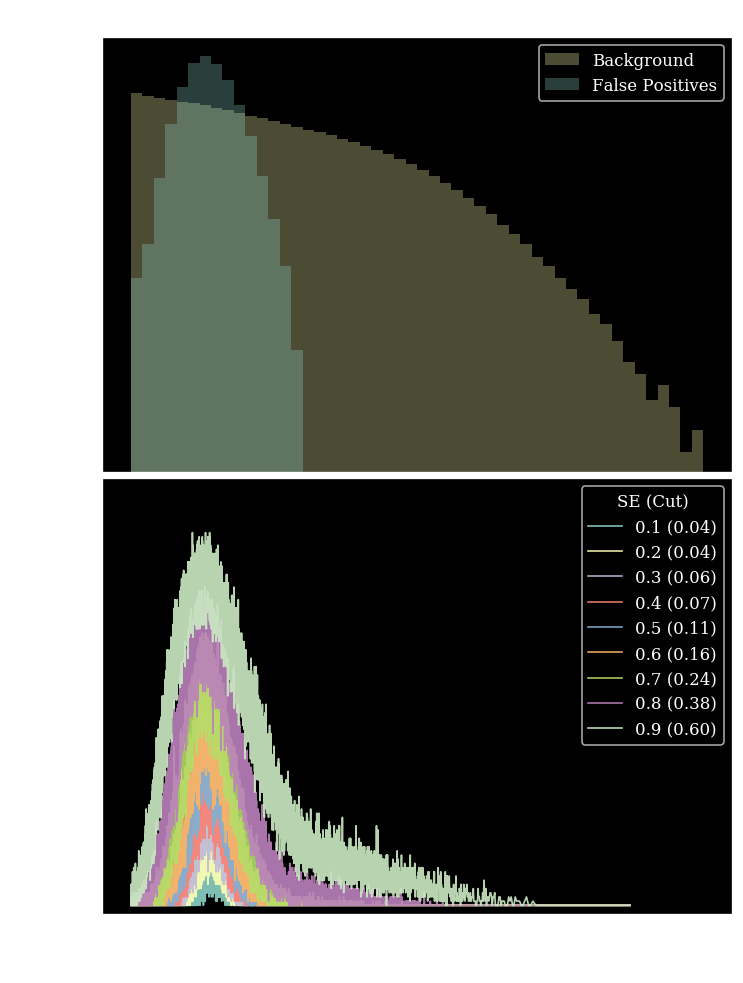

strength 0.01
Entering Training...
Epoch:0001/0200  (7.8  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (134.5s)
 Train: loss:0.2003, acc:81% || Val: loss: 0.0566, acc:84%, R50: 22.7523, 1/JSD: 113.3680
Epoch:0200/0200  (262.3s)
 Train: loss:0.1880, acc:81% || Val: loss: 0.0552, acc:85%, R50: 23.8767, 1/JSD: 82.0027


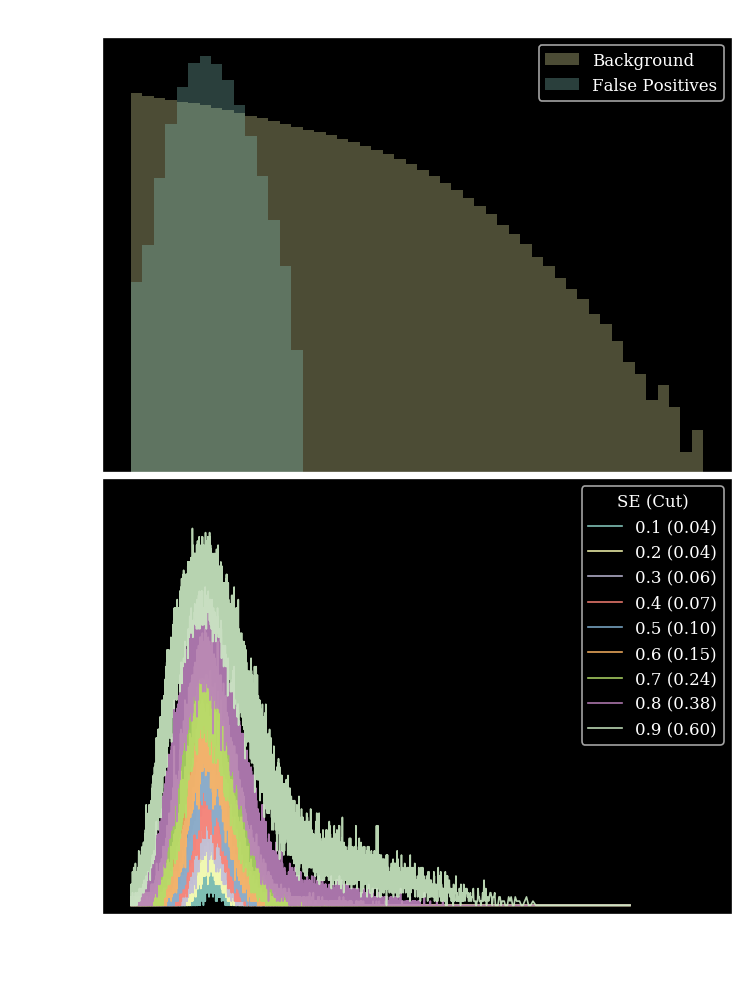

[(110.95870344155618, 22.735996692945935), (103.56083167346208, 22.95697802689246), (98.517706339172, 23.39430029774564), (102.9897364019979, 23.396432803621888), (99.03563015224016, 23.90265102129509), (96.0559708083862, 23.57768387531386), (96.03221362268769, 23.61890739547867), (97.22312583257127, 23.510732496717655), (97.25118256029755, 23.515758612264843)]


In [7]:
jsd_r50 = list()
for i,frac in enumerate([120,100,75,50,10,5,1,1e-1,1e-2]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
    loss =  FlatLoss(labels=traindataset.labels,frac=frac,sbins=100)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNnaiveLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"Flat DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50.append(out)
print(jsd_r50)

In [8]:
asdasd 

NameError: name 'asdasd' is not defined

# DisCo

strength 0.01
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (308.3s)
 Train: loss:0.2002, acc:81% || Val: loss: 0.0566, acc:84%, R50: 22.7571, 1/JSD: 113.2046
Epoch:0200/0200  (601.6s)
 Train: loss:0.1881, acc:81% || Val: loss: 0.0552, acc:85%, R50: 23.8767, 1/JSD: 82.0444


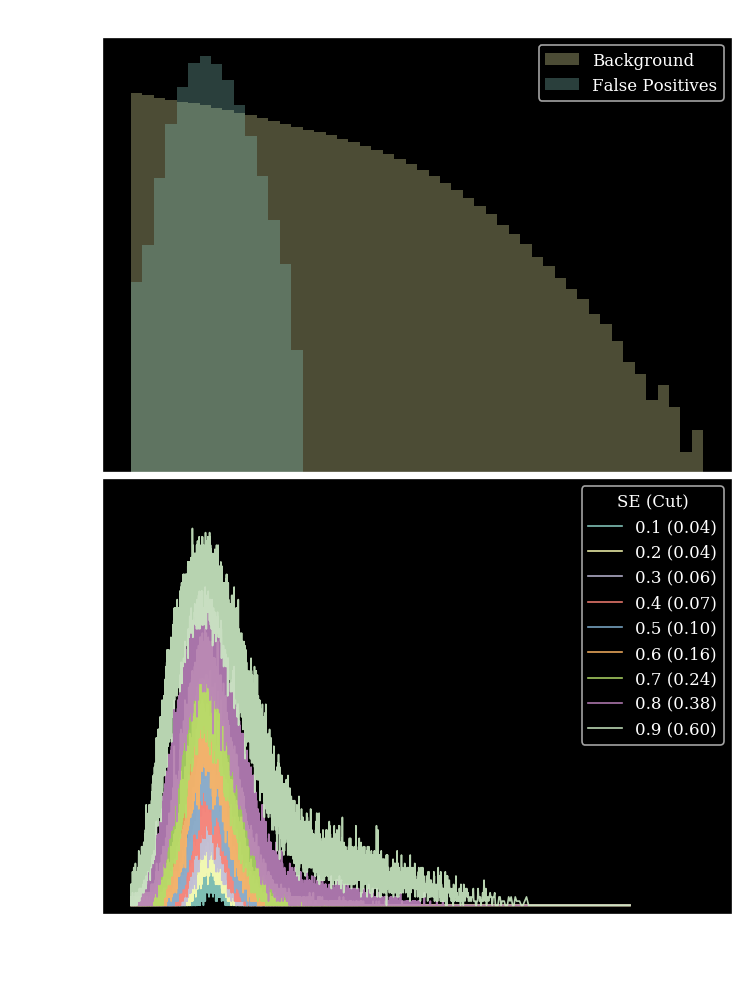

strength 0.1
Entering Training...
Epoch:0001/0200  (7.9  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (298.3s)
 Train: loss:0.2005, acc:81% || Val: loss: 0.0566, acc:84%, R50: 22.7618, 1/JSD: 113.2019
Epoch:0200/0200  (599.6s)
 Train: loss:0.1880, acc:81% || Val: loss: 0.0552, acc:85%, R50: 23.8905, 1/JSD: 82.2827


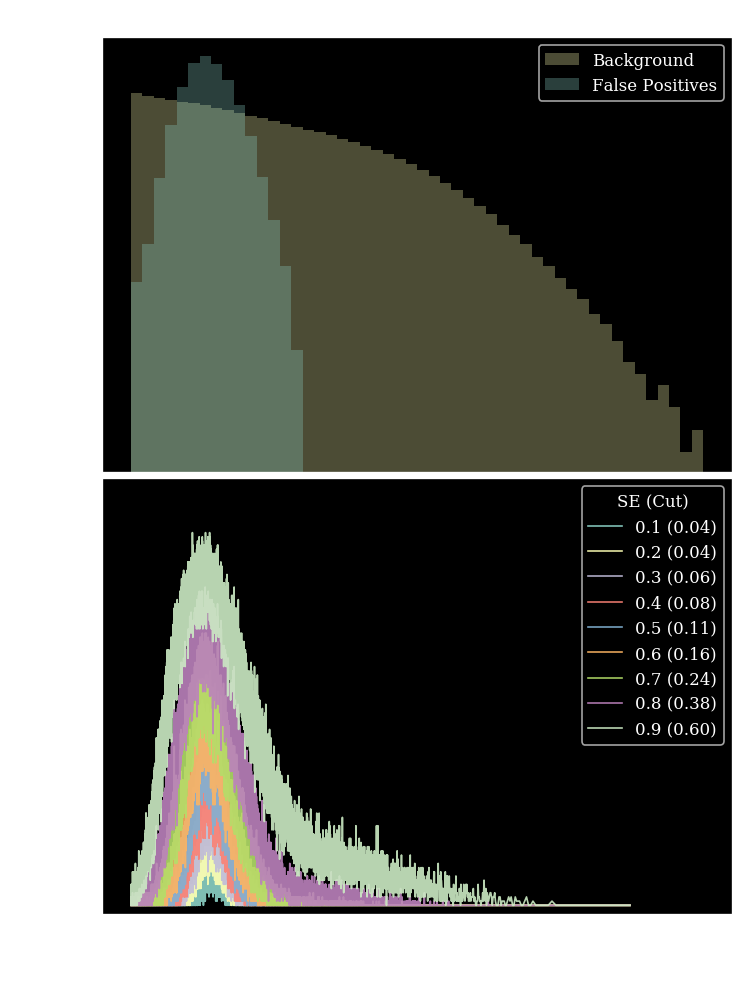

strength 1
Entering Training...
Epoch:0001/0200  (7.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (297.5s)
 Train: loss:0.2026, acc:81% || Val: loss: 0.0567, acc:84%, R50: 22.6913, 1/JSD: 114.0688
Epoch:0200/0200  (591.4s)
 Train: loss:0.1890, acc:81% || Val: loss: 0.0547, acc:84%, R50: 23.6576, 1/JSD: 81.5067


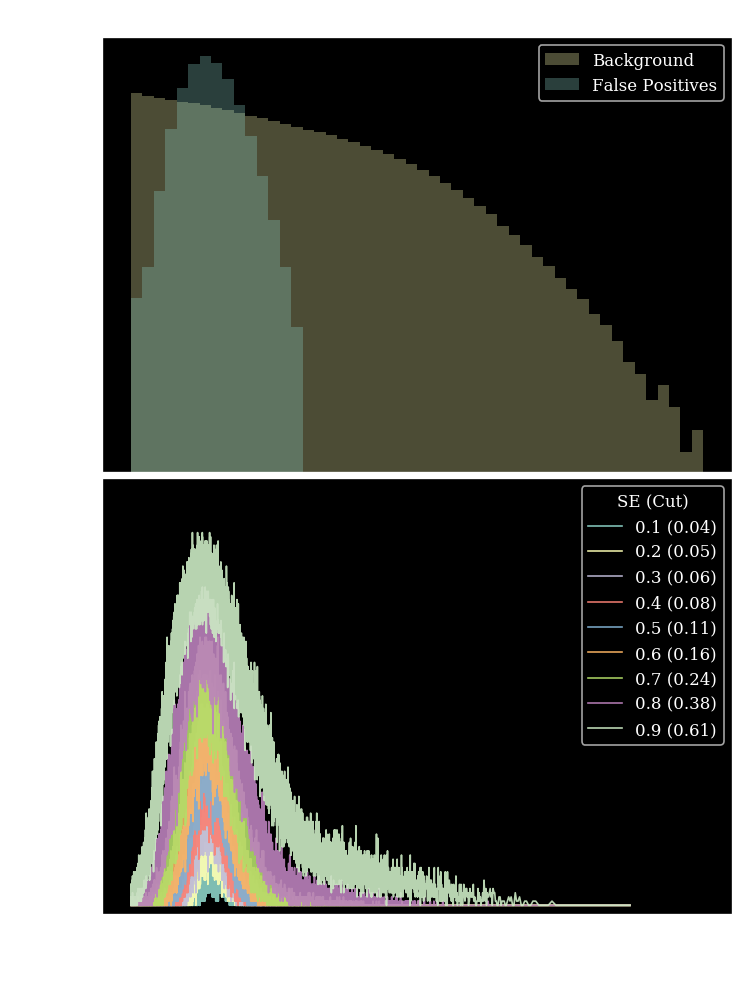

strength 5
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (295.2s)
 Train: loss:0.2125, acc:81% || Val: loss: 0.0567, acc:84%, R50: 22.5302, 1/JSD: 113.8284
Epoch:0200/0200  (586.9s)
 Train: loss:0.1937, acc:80% || Val: loss: 0.0539, acc:82%, R50: 23.5900, 1/JSD: 88.3793


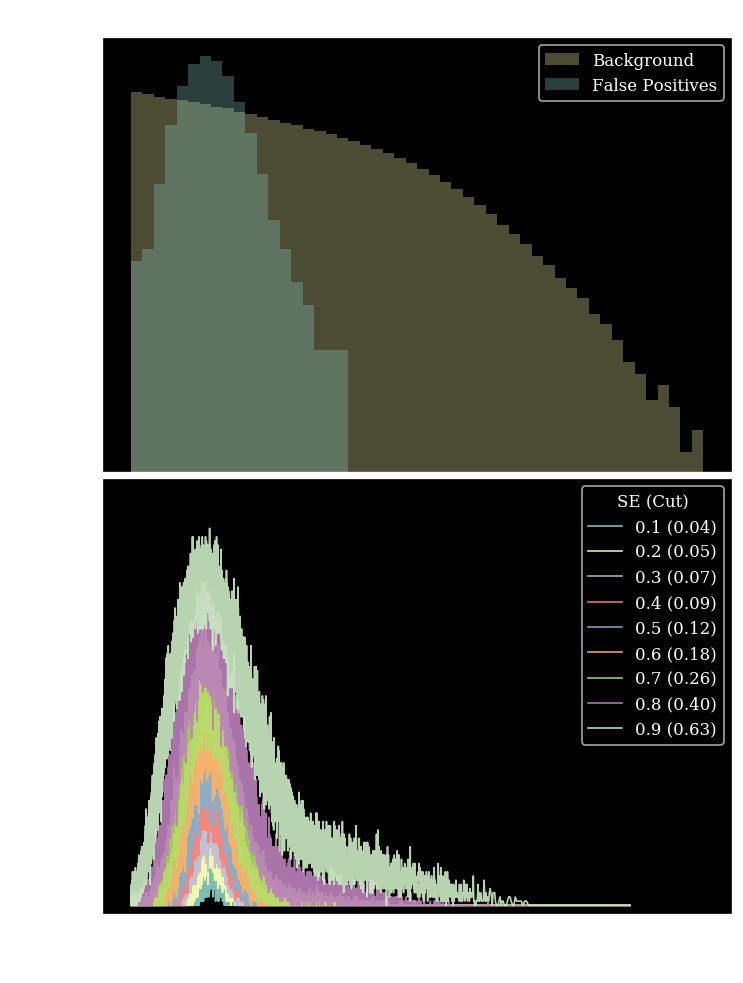

strength 10
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (329.5s)
 Train: loss:0.2259, acc:81% || Val: loss: 0.0557, acc:83%, R50: 22.2058, 1/JSD: 108.3004
Epoch:0200/0200  (674.6s)
 Train: loss:0.1991, acc:80% || Val: loss: 0.0541, acc:82%, R50: 23.6322, 1/JSD: 82.4433


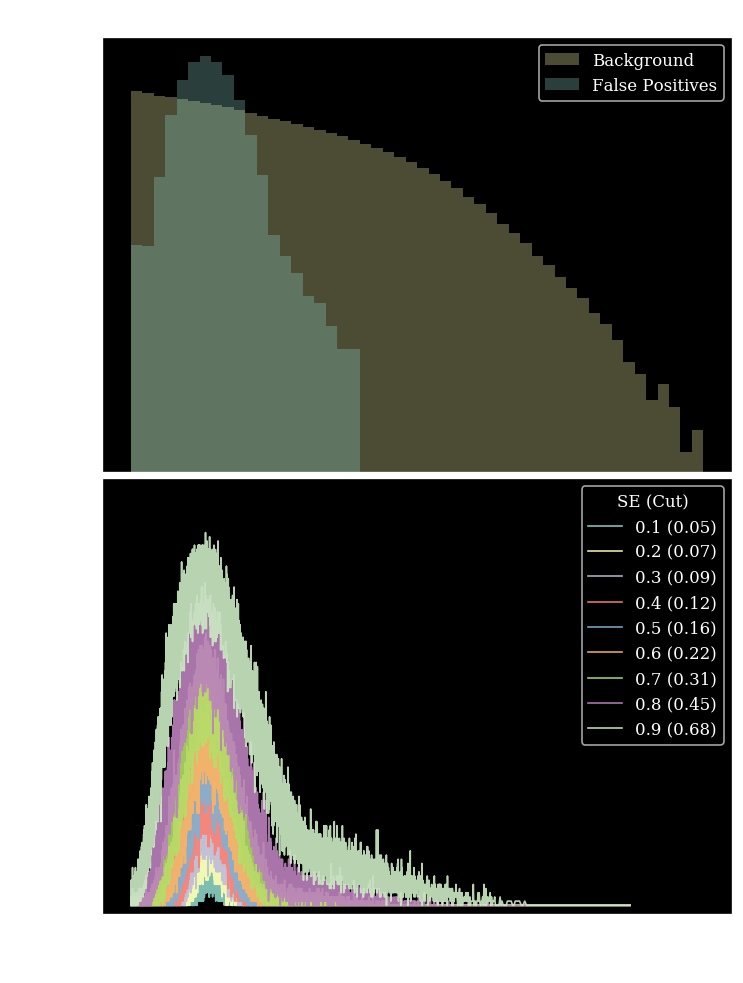

strength 50
Entering Training...
Epoch:0001/0200  (9.0  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (351.6s)
 Train: loss:0.3125, acc:79% || Val: loss: 0.0588, acc:80%, R50: 18.8971, 1/JSD: 114.8514
Epoch:0200/0200  (690.4s)
 Train: loss:0.2820, acc:75% || Val: loss: 0.0652, acc:80%, R50: 15.3317, 1/JSD: 182.5779


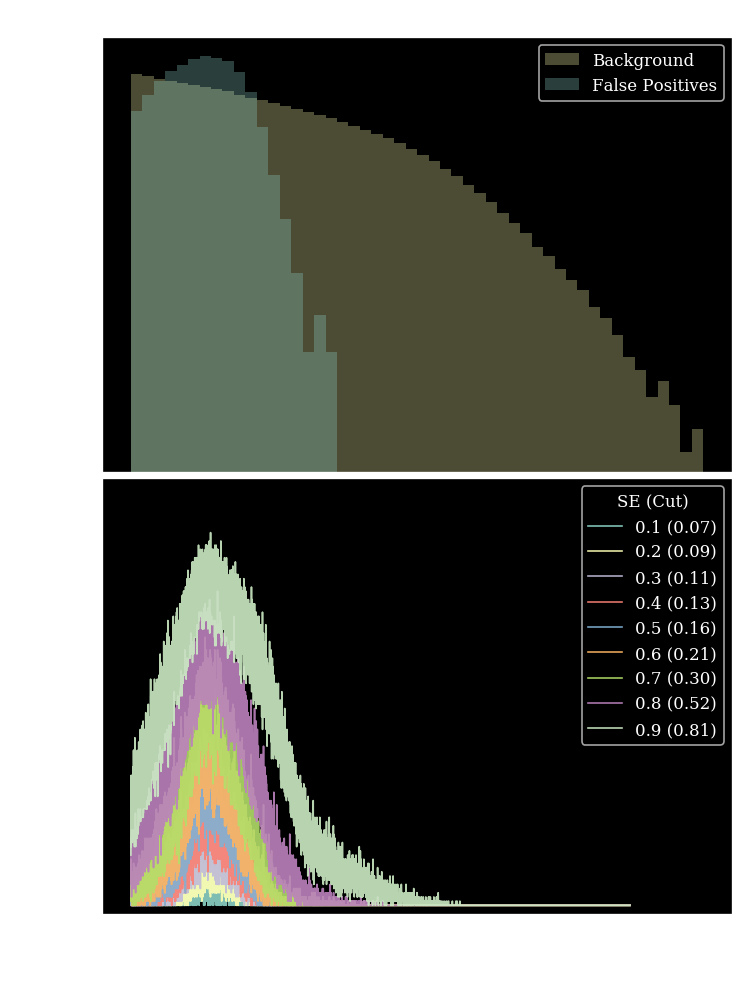

strength 75
Entering Training...
Epoch:0001/0200  (7.7  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (311.6s)
 Train: loss:0.4083, acc:76% || Val: loss: 0.0692, acc:76%, R50: 9.6087, 1/JSD: 154.8829
Epoch:0200/0200  (654.6s)
 Train: loss:0.3136, acc:78% || Val: loss: 0.0643, acc:75%, R50: 17.2874, 1/JSD: 174.4515


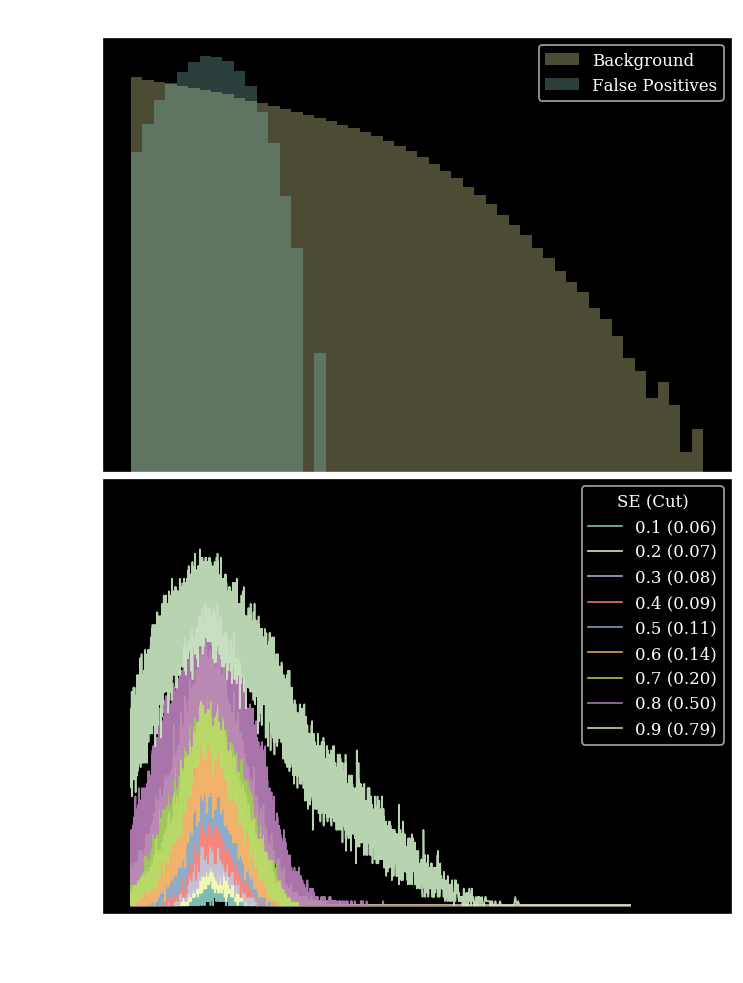

strength 100
Entering Training...
Epoch:0001/0200  (9.5  s)
 Train: loss:0.0000, acc:0% || Val: loss: 0.0975, acc:20%, R50: 2.4155, 1/JSD: 8513.3068
Epoch:0100/0200  (347.6s)
 Train: loss:0.6239, acc:73% || Val: loss: 0.0716, acc:73%, R50: 11.1483, 1/JSD: 374.6642
Epoch:0200/0200  (707.7s)
 Train: loss:0.2988, acc:72% || Val: loss: 0.0722, acc:82%, R50: 13.4310, 1/JSD: 254.3994


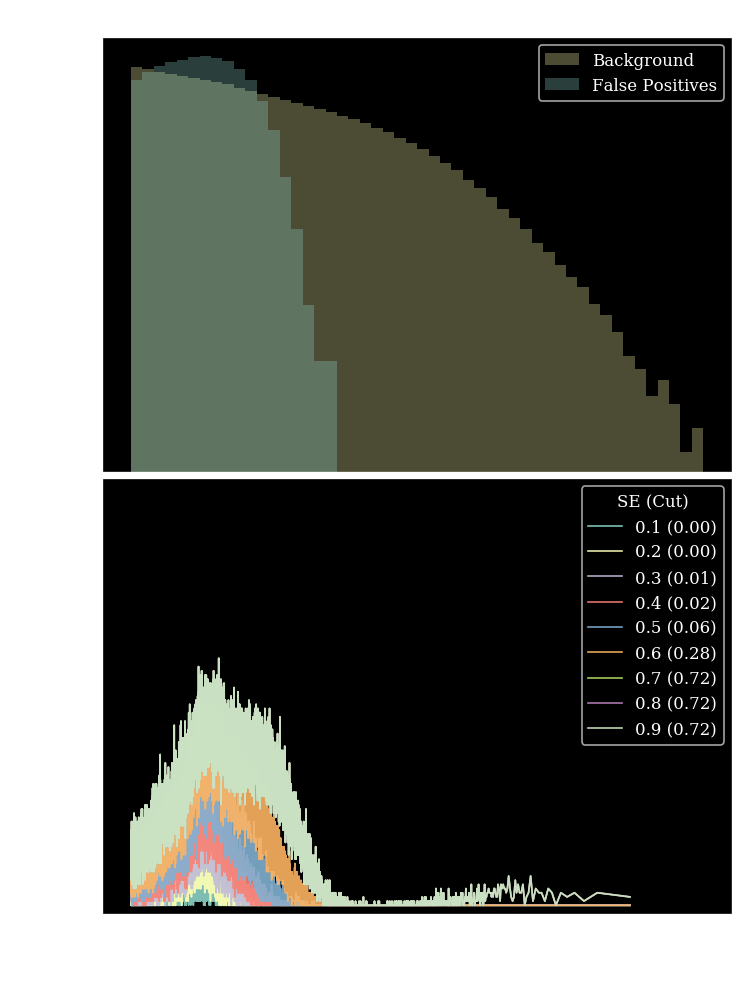

[(97.46604785436945, 23.540201773158056), (97.01999150805749, 23.522223919352374), (94.99657159135886, 23.351731667374295), (80.71890191936563, 23.186485591255384), (82.92063962201382, 23.56758080313418), (196.99621832719515, 18.57256566728575), (161.2694110157966, 18.718852558648354), (295.09075405780476, 13.629042250030976)]


In [8]:
jsd_r50_2= list()
for i,frac in enumerate([100,75,50,10,5,1,1e-1,1e-2][::-1]):
    print("strength",frac)
    metrics_train_L = Metrics()
    metrics_val_L = Metrics(validation=True)

    torch.manual_seed(777)
    model_L = Classifier().to(device)
    optimizer = torch.optim.SGD(model_L.parameters(),lr=2e-1,momentum=0.)
    loss =  Disco(frac=frac,labels=traindataset.labels,background_only=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
    log=Logger("./logs/logWFCNDisLoss({:.2f}).txt".format(frac))
    model_L.fit(traindataset=traindataset,
                valdataset=valdataset,
                optimizer=optimizer,
                loss=loss,
                **params,
                log=log,
              #scheduler=scheduler,
              metrics=[metrics_train_L,metrics_val_L])
    out=plot_stuff(model=model_L,name=f"DisCo DNN str:{frac}",X=test[:,1:11],y=test_labels,x_biased=test[:,0])
    jsd_r50_2.append(out)
print(jsd_r50_2)